# Test accuracies of best models

list accuracy on test dataset for no data leakage

In [55]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [146]:
model = torch.load('./upperlower_best.pt')
test_img_path = '/home/riikoro/fossil_data/tooth_samples/torch_imagefolder_0/upperlower/test'
confidence_threshold = 0.997

In [147]:
mean = [0.5, 0.5, 0.5]
std = [0.2, 0.2, 0.2]
data_transforms = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [148]:
test_dataset = datasets.ImageFolder(test_img_path, data_transforms)
class_names = test_dataset.classes
print(class_names)
sample_count = len(test_dataset.imgs)
print(sample_count)
test_dataset

['low', 'up']
78


Dataset ImageFolder
    Number of datapoints: 78
    Root location: /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_0/upperlower/test
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=3)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2])
           )

In [149]:
dataloader = torch.utils.data.DataLoader(test_dataset)
dataloader

In [150]:
running_corrects = 0
running_certain = 0
misclassified_images = []
predicted = []

for inputs, labels in dataloader:
    outputs = model(inputs)
    if outputs.max() > confidence_threshold:
        running_certain +=1
    _, predictions = torch.max(outputs, 1)
    running_corrects += torch.sum(predictions == labels.data)

    # save misclassifications for visualization
    if (predictions.item() != labels.data.item()):
        misclassified_images.append(inputs.squeeze(0))
        predicted.append(predictions)

accuracy = running_corrects / sample_count
certainty = running_certain / sample_count
print(f'Certain classifications: {running_certain}')
print(f'Certainty rate: {certainty}')
print(f'Accuracy: {accuracy.item()}')

Certain classifications: 56
Certainty rate: 0.717948717948718
Accuracy: 0.9230769276618958


In [151]:
prediction = predicted[0]
title = 'Predicted: up, correct: low' if prediction.item() == 1 else 'Predicted: low, correct: up'
title

'Predicted: up, correct: low'

In [161]:
def imshow(inp, title=None, filename=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    means = np.array(mean)
    stds = np.array(std)
    inp = stds * inp + means
    inp = np.clip(inp, 0, 1)
    fig,ax = plt.subplots(1)
    ax.axis('off')
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    if filename is not None:
        fig.savefig(filename)
    plt.pause(0.001)  # pause a bit so that plots are updated

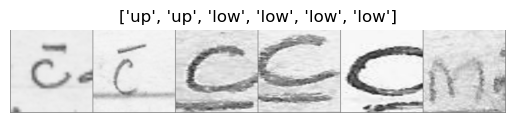

In [163]:
inputs = torch.stack(misclassified_images)
titles = ['up' if prediction.item() == 1 else 'low' for prediction in predicted]

# # Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, titles, '../../../tex/images/misclassified_uplow.png')